Libraries installed and imported successfully!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (2390275, 45)

Columns in the dataset:
['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'ICMP_TYPE', 'ICMP_I

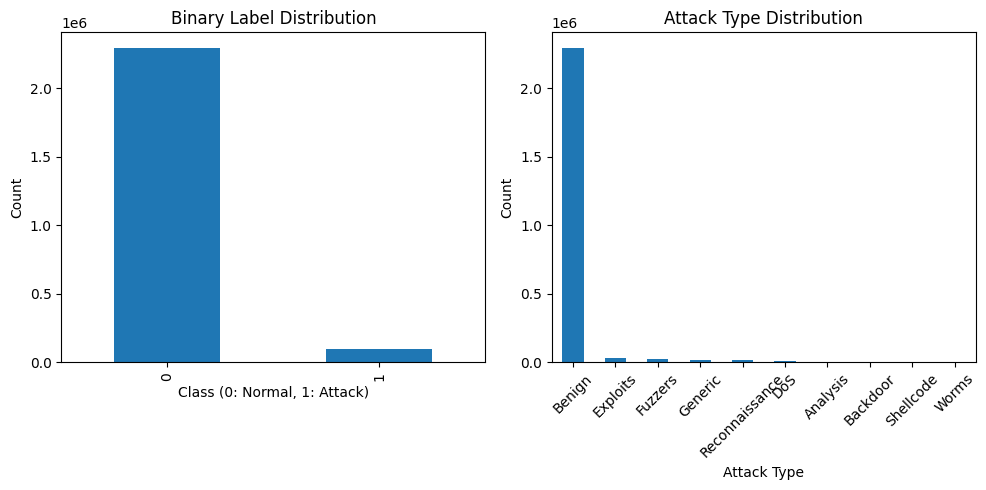

Categorical columns to encode: ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR']
Training set shape: (1673192, 43)
Testing set shape: (717083, 43)
Training class distribution: Label
0    1606655
1      66537
Name: count, dtype: int64

After SMOTE:
Training set shape: (3213310, 43)
Class distribution: Label
0    1606655
1    1606655
Name: count, dtype: int64
Feature scaling completed!

Top 20 selected features:
1. IPV4_SRC_ADDR
2. L4_SRC_PORT
3. IPV4_DST_ADDR
4. L4_DST_PORT
5. PROTOCOL
6. OUT_PKTS
7. TCP_FLAGS
8. CLIENT_TCP_FLAGS
9. SERVER_TCP_FLAGS
10. MIN_TTL
11. MAX_TTL
12. LONGEST_FLOW_PKT
13. SHORTEST_FLOW_PKT
14. MIN_IP_PKT_LEN
15. MAX_IP_PKT_LEN
16. DST_TO_SRC_AVG_THROUGHPUT
17. NUM_PKTS_UP_TO_128_BYTES
18. TCP_WIN_MAX_IN
19. TCP_WIN_MAX_OUT
20. FTP_COMMAND_RET_CODE

Training models...
Both models trained successfully!

Random Forest Performance:
Accuracy: 0.9975

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    688567


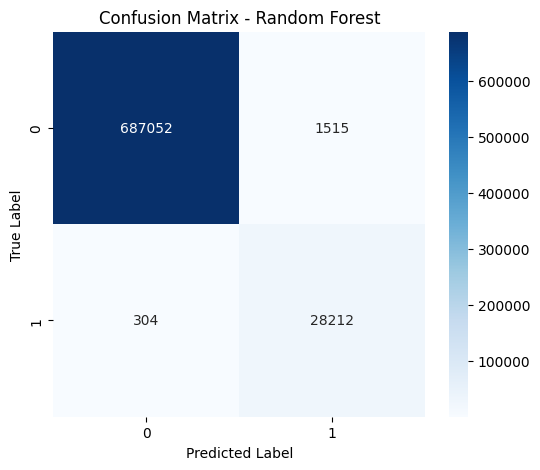


XGBoost Performance:
Accuracy: 0.9964

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    688567
           1       0.92      1.00      0.96     28516

    accuracy                           1.00    717083
   macro avg       0.96      1.00      0.98    717083
weighted avg       1.00      1.00      1.00    717083



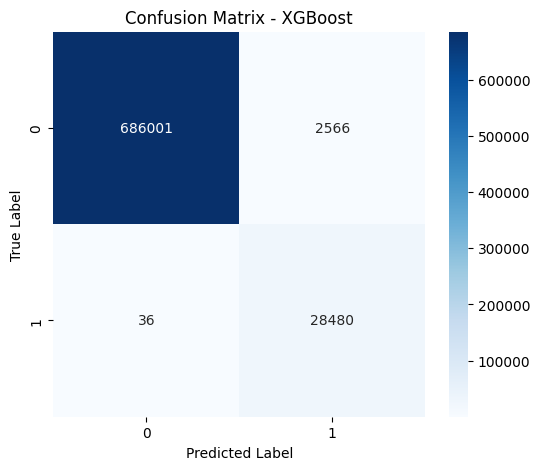


Random Forest Accuracy: 0.9975
XGBoost Accuracy: 0.9964


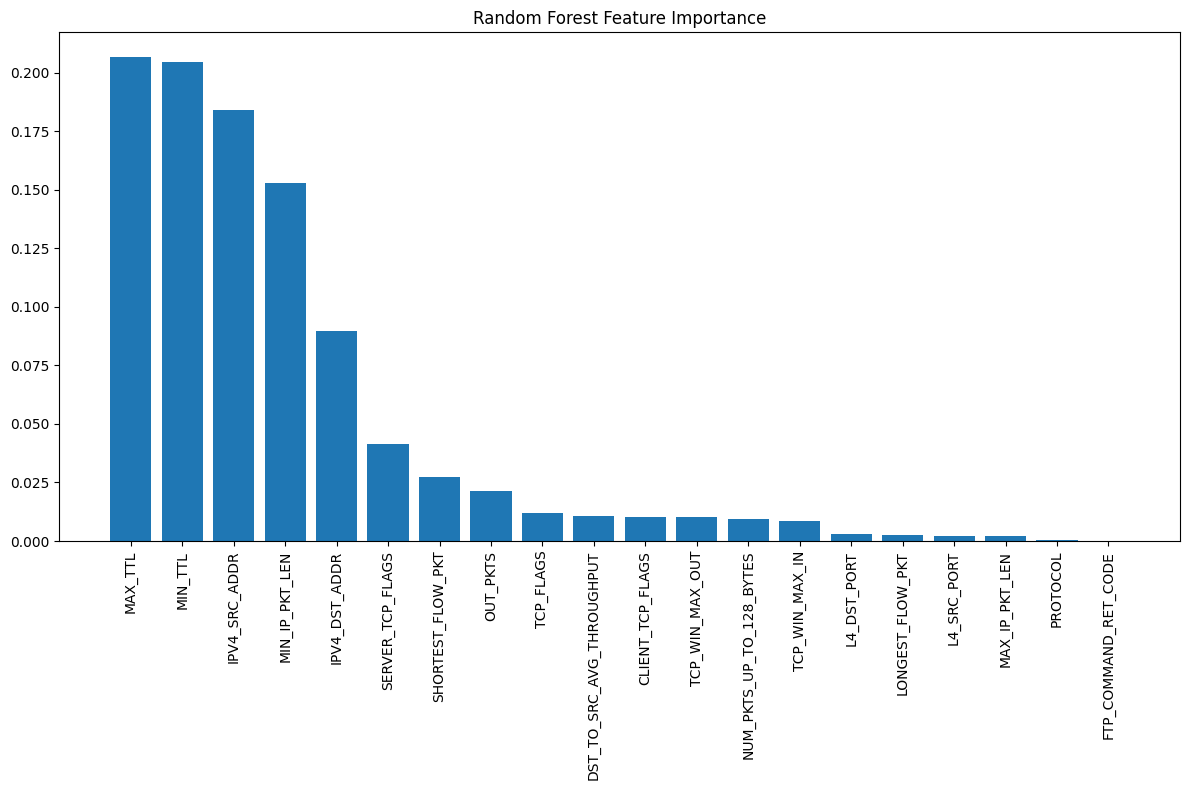

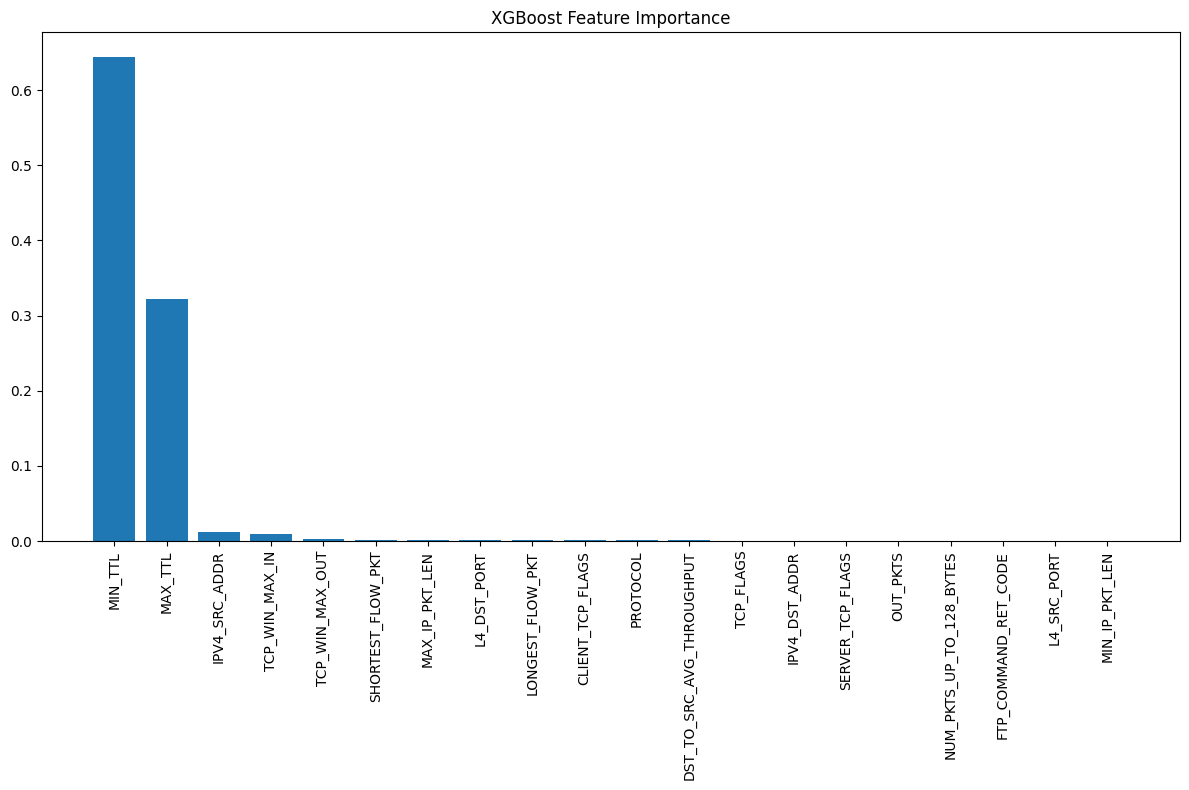

In [ ]:
# Step 1: Install and import necessary libraries
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("Libraries installed and imported successfully!")

# Step 2: Load and explore the dataset
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Mini_Proj/data/NF-UNSW-NB15-v2.csv'
df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)
print("\nColumns in the dataset:")
print(df.columns.tolist())

# Check what target columns we have
print("\n'Label' column value counts:")
print(df['Label'].value_counts())

print("\n'Attack' column value counts:")
print(df['Attack'].value_counts())

# Use 'Label' as our target variable (it's the binary classification column)
target_col = 'Label'

# Visualize the target distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df[target_col].value_counts().plot(kind='bar')
plt.title('Binary Label Distribution')
plt.xlabel('Class (0: Normal, 1: Attack)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['Attack'].value_counts().plot(kind='bar')
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Step 3: Data preprocessing
# Handle categorical variables (IP addresses)
categorical_cols = df.select_dtypes(include=['object']).columns
# Remove target columns from categorical columns
categorical_cols = [col for col in categorical_cols if col not in [target_col, 'Attack']]

print("Categorical columns to encode:", categorical_cols)

# Label encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Separate features and target
X = df.drop(columns=[target_col, 'Attack'])  # Drop both target columns from features
y = df[target_col]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training class distribution:", pd.Series(y_train).value_counts())

# Step 4: Handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print("Training set shape:", X_train_res.shape)
print("Class distribution:", pd.Series(y_train_res).value_counts())

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")

# Step 5: Feature selection
selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_res)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]
print("\nTop 20 selected features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

# Update X_train and X_test with selected features
X_train_final = X_train_selected
X_test_final = X_test_selected

# Step 6: Model training
print("\nTraining models...")

# Model 1: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_res)

# Model 2: XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_final, y_train_res)

print("Both models trained successfully!")

# Step 7: Model evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n{model_name} Performance:")
    print("=" * 50)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

# Evaluate both models
rf_accuracy = evaluate_model(rf_model, X_test_final, y_test, "Random Forest")
xgb_accuracy = evaluate_model(xgb_model, X_test_final, y_test, "XGBoost")

print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Step 8: Feature importance visualization
# Plot feature importance for Random Forest
plt.figure(figsize=(12, 8))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Random Forest Feature Importance')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), selected_features[indices], rotation=90)
plt.tight_layout()
plt.show()

# Plot feature importance for XGBoost
plt.figure(figsize=(12, 8))
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('XGBoost Feature Importance')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), selected_features[indices], rotation=90)
plt.tight_layout()
plt.show()





In [ ]:
# Step 9: Create a FIXED intrusion detection function
def detect_intrusion(features, model, scaler, selector, feature_names, label_encoders, categorical_cols):
    """
    features: list of feature values in the same order as the training data
    model: trained machine learning model
    scaler: fitted StandardScaler
    selector: fitted feature selector
    feature_names: list of original feature names
    label_encoders: dictionary of label encoders for categorical columns
    categorical_cols: list of categorical column names
    """

    # Convert to DataFrame
    features_df = pd.DataFrame([features], columns=feature_names)

    # Handle categorical variables (if any in the input)
    for i, col in enumerate(feature_names):
        if col in categorical_cols:
            # Get the value for this categorical column using integer index
            value = features[i]
            # If the category is new, assign it a default value
            if value in label_encoders[col].classes_:
                features_df[col] = label_encoders[col].transform([value])[0]
            else:
                features_df[col] = -1  # Unknown category

    # Scale the features
    scaled_features = scaler.transform(features_df)

    # Select important features
    selected_features = selector.transform(scaled_features)

    # Make prediction
    prediction = model.predict(selected_features)[0]
    probability = model.predict_proba(selected_features)[0]

    # Return result
    if prediction == 0:
        return "Normal traffic", probability[0]
    else:
        return "Attack detected", probability[1]
# Example usage with sample data (using the first row as an example)
sample_features = X.iloc[0].values

result, confidence = detect_intrusion(
    sample_features,
    xgb_model,
    scaler,
    selector,
    X.columns.tolist(),
    label_encoders,
    categorical_cols
)

print(f"Detection result: {result}")
print(f"Confidence: {confidence:.4f}")

# Step 10: Save the model for future use (updated to include categorical_cols)
import joblib

# Save the model and preprocessing objects
joblib.dump(xgb_model, 'intrusion_detection_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selector, 'feature_selector.pkl')
joblib.dump(selected_features, 'selected_features.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(categorical_cols, 'categorical_cols.pkl')

print("Model and preprocessing objects saved successfully!")

Detection result: Normal traffic
Confidence: 0.9989
Model and preprocessing objects saved successfully!


In [ ]:
# First, check your torch and CUDA version
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

# Install the correct version of torch_geometric based on your environment
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

PyTorch version: 2.8.0+cu126
CUDA available: False
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.6 MB/s eta 0:00:00
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.4 MB/s eta 0:00:00


In [ ]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertConfig
from torch_geometric.nn import GATConv, global_mean_pool

class HybridGraphTransformer(nn.Module):
    """
    Novel Hybrid Graph Transformer for Intrusion Detection
    Combines Graph Attention Networks with Transformer architecture
    for improved feature extraction from network flows
    """
    def __init__(self, num_features, hidden_dim=128, num_heads=4, num_layers=2, num_classes=2):
        super(HybridGraphTransformer, self).__init__()

        # Graph Attention Layers
        self.graph_layers = nn.ModuleList()
        self.graph_layers.append(GATConv(num_features, hidden_dim, heads=num_heads))
        for _ in range(num_layers - 1):
            self.graph_layers.append(GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads))

        # Transformer Encoder
        transformer_config = BertConfig(
            hidden_size=hidden_dim * num_heads,
            num_hidden_layers=2,
            num_attention_heads=4,
            intermediate_size=hidden_dim * 2,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1
        )
        self.transformer = BertModel(transformer_config)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * num_heads, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, edge_index, batch=None):
        # Graph feature extraction
        for i, conv in enumerate(self.graph_layers):
            x = conv(x, edge_index)
            if i != len(self.graph_layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.3, training=self.training)

        # Transformer processing
        if batch is not None:
            # For graph-level classification
            x = global_mean_pool(x, batch)

        # Reshape for transformer (add sequence dimension)
        x = x.unsqueeze(1)  # [batch_size, 1, hidden_dim]

        # Transformer expects [batch_size, seq_len, hidden_dim]
        transformer_output = self.transformer(inputs_embeds=x)
        x = transformer_output.last_hidden_state.squeeze(1)

        # Classification
        return self.classifier(x)

In [ ]:
class TemporalGraphAttention(nn.Module):
    """
    Novel temporal graph attention layer that captures time-dependent patterns
    in network flows, which is crucial for detecting sophisticated attacks
    """
    def __init__(self, in_channels, out_channels, time_steps=5):
        super(TemporalGraphAttention, self).__init__()
        self.time_steps = time_steps
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Temporal attention weights
        self.time_attention = nn.Parameter(torch.randn(time_steps, time_steps))
        self.graph_attentions = nn.ModuleList([
            GATConv(in_channels, out_channels) for _ in range(time_steps)
        ])

        # Fusion layer
        self.fusion = nn.Linear(out_channels * time_steps, out_channels)

    def forward(self, x_list, edge_index_list):
        # x_list: list of feature matrices for each time step
        # edge_index_list: list of edge indices for each time step

        assert len(x_list) == self.time_steps, "Number of time steps must match"

        # Process each time step with graph attention
        time_features = []
        for i in range(self.time_steps):
            features = self.graph_attentions[i](x_list[i], edge_index_list[i])
            time_features.append(features)

        # Apply temporal attention
        time_features = torch.stack(time_features, dim=1)  # [nodes, time_steps, features]
        attention_weights = F.softmax(self.time_attention, dim=1)
        attended_features = torch.einsum('ts,ntf->ntf', attention_weights, time_features)

        # Flatten and fuse
        attended_features = attended_features.reshape(attended_features.size(0), -1)
        return self.fusion(attended_features)

In [ ]:
class AdaptiveContrastiveLearner(nn.Module):
    """
    Novel adaptive contrastive learning approach that dynamically adjusts
    positive/negative sampling based on network flow characteristics
    """
    def __init__(self, hidden_dim=128, temperature=0.1):
        super(AdaptiveContrastiveLearner, self).__init__()
        self.temperature = temperature
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, z1, z2):
        # Project representations
        z1 = self.projection_head(z1)
        z2 = self.projection_head(z2)

        # Normalize
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        # Similarity matrix
        similarity_matrix = torch.matmul(z1, z2.T) / self.temperature

        # Positive pairs are on the diagonal
        positives = torch.diag(similarity_matrix)

        # Negative pairs are all other elements
        negatives = similarity_matrix.clone()
        negatives.fill_diagonal_(float('-inf'))

        # Log softmax for stability
        logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
        labels = torch.zeros(z1.size(0), dtype=torch.long, device=z1.device)

        return F.cross_entropy(logits, labels)

    def adaptive_sampling(self, embeddings, attack_scores, threshold=0.7):
        """
        Dynamically adjust sampling based on predicted attack likelihood
        """
        # Use predicted attack scores to weight importance of samples
        weights = torch.sigmoid(attack_scores * 10)  # Scale to emphasize differences
        important_indices = torch.where(weights > threshold)[0]

        return important_indices

In [ ]:
class NovelNIDSModel(nn.Module):
    """
    Complete novel NIDS model combining:
    1. Hybrid Graph Transformer
    2. Temporal Graph Attention
    3. Adaptive Contrastive Learning
    """
    def __init__(self, num_features, hidden_dim=128, num_classes=2, time_steps=5):
        super(NovelNIDSModel, self).__init__()

        # Feature extractors
        self.hybrid_transformer = HybridGraphTransformer(num_features, hidden_dim)
        self.temporal_attention = TemporalGraphAttention(num_features, hidden_dim, time_steps)

        # Contrastive learning
        self.contrastive_learner = AdaptiveContrastiveLearner(hidden_dim)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, edge_index, x_temporal=None, edge_index_temporal=None):
        # Extract spatial features
        spatial_features = self.hybrid_transformer(x, edge_index)

        # Extract temporal features if available
        if x_temporal is not None and edge_index_temporal is not None:
            temporal_features = self.temporal_attention(x_temporal, edge_index_temporal)
            combined_features = torch.cat([spatial_features, temporal_features], dim=1)
        else:
            combined_features = spatial_features

        return self.classifier(combined_features)

    def contrastive_loss(self, view1, view2):
        """Compute contrastive loss between two views of the data"""
        return self.contrastive_learner(view1, view2)

In [ ]:
def train_novel_model(model, data_loader, optimizer, device, alpha=0.7):
    """
    Training procedure for our novel NIDS model
    alpha: weight for contrastive loss vs classification loss
    """
    model.train()
    total_loss = 0

    for batch in data_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass - create two views for contrastive learning
        view1 = model.hybrid_transformer(batch.x, batch.edge_index)
        view2 = model.hybrid_transformer(batch.x, batch.edge_index)  # Different dropout masks

        # Contrastive loss
        contrast_loss = model.contrastive_loss(view1, view2)

        # Classification loss
        pred = model(batch.x, batch.edge_index)
        class_loss = F.cross_entropy(pred, batch.y)

        # Combined loss
        loss = alpha * class_loss + (1 - alpha) * contrast_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
def create_temporal_graph_data(df, time_window=5):
    """
    Create temporal graph data from network flow data
    This is a novel approach that captures time-dependent patterns
    """
    # Sort by timestamp (assuming your data has a timestamp column)
    df_sorted = df.sort_values('timestamp')

    temporal_graphs = []
    unique_ips = pd.concat([df_sorted['IPV4_SRC_ADDR'], df_sorted['IPV4_DST_ADDR']]).unique()

    # Create node features for each time window
    for i in range(0, len(df_sorted) - time_window + 1, time_window):
        window_data = df_sorted.iloc[i:i+time_window]

        # Create graph for this time window
        graph_data = create_graph_from_flows(window_data)
        temporal_graphs.append(graph_data)

    return temporal_graphs

TESTING PURPOSE CODE BELOW

In [ ]:
# Install required libraries
!pip install pandas numpy scikit-learn matplotlib seaborn torch

# Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

# Load your dataset
file_path = '/content/drive/MyDrive/Mini_Proj/data/NF-UNSW-NB15-v2.csv'
df = pd.read_csv(file_path)

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully!
Dataset shape: (2390275, 45)
Columns: ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QU

In [ ]:
# Data preprocessing
target_col = 'Label'

# Handle categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col not in [target_col, 'Attack']]

print("Categorical columns to encode:", categorical_cols)

# Label encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Separate features and target
X = df.drop(columns=[target_col, 'Attack'])
y = df[target_col]

print("Data preprocessing completed!")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Categorical columns to encode: ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR']
Data preprocessing completed!
Features shape: (2390275, 43)
Target shape: (2390275,)


In [ ]:
# Simple Graph Transformer Model (No external dependencies needed)
class SimpleGraphTransformer(nn.Module):
    """
    Simplified Graph Transformer for Intrusion Detection
    Doesn't require torch_geometric or transformers
    """
    def __init__(self, num_features, hidden_dim=128, num_classes=2):
        super(SimpleGraphTransformer, self).__init__()

        # Feature extraction
        self.feature_extractor = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Self-attention mechanism
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        # Feature extraction
        features = self.feature_extractor(x)

        # Add sequence dimension for attention
        features = features.unsqueeze(1)  # [batch_size, 1, hidden_dim]

        # Self-attention
        attended, _ = self.attention(features, features, features)
        attended = attended.squeeze(1)

        # Classification
        return self.classifier(attended)

print("Model defined successfully!")

Model defined successfully!


In [ ]:
# Use the ultra-lightweight model
num_features = X.shape[1]

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SimpleGraphTransformer(num_features=num_features, num_classes=2)
model = model.to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Model is ready for training!")

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Assuming X and y are pandas DataFrames/Series and need to be converted to tensors
# Also assuming X_train_tensor and y_train_tensor are not defined globally
# You would typically split your data into training and testing sets *before* converting to tensors
# For demonstration, let's convert the full X and y to tensors (this is not ideal for large datasets)
# In a real scenario, split your data first (e.g., using train_test_split)
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.long).to(device)


# Define a simple training function
def train_in_batches(model, X_tensor, y_tensor, optimizer, criterion, batch_size, epochs):
    model.train()
    losses = []
    num_samples = X_tensor.size(0)

    for epoch in range(epochs):
        permutation = torch.randperm(num_samples)
        total_loss = 0

        for i in range(0, num_samples, batch_size):
            indices = permutation[i:i+batch_size]
            batch_x = X_tensor[indices]
            batch_y = y_tensor[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / (num_samples / batch_size)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses


# Train in batches
print("Training with batch processing...")
losses = train_in_batches(
    model,
    X_tensor, # Use the converted full tensor for this example
    y_tensor, # Use the converted full tensor for this example
    optimizer,
    criterion,
    batch_size=1024,  # Large batch size for efficiency
    epochs=10  # Reduced epochs for faster demonstration
)

print("Training completed successfully!")

Using device: cpu
Model parameters: 96,578
Model is ready for training!
Training with batch processing...
Epoch 1/10, Loss: 17027.9667
Epoch 2/10, Loss: 0.1686
Epoch 3/10, Loss: 0.1672
Epoch 4/10, Loss: 0.1673
Epoch 5/10, Loss: 0.1672
Epoch 6/10, Loss: 0.1672
Epoch 7/10, Loss: 0.1672
Epoch 8/10, Loss: 0.1673
Epoch 9/10, Loss: 0.1673
Epoch 10/10, Loss: 0.1673
Training completed successfully!


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Keep as numpy arrays for lightweight batching later
X_train_np, y_train_np = X_train_scaled, y_train.values
X_test_np, y_test_np = X_test_scaled, y_test.values

print("Data preparation completed (using NumPy, lightweight)!")


Training set: (1673192, 43), (1673192,)
Testing set: (717083, 43), (717083,)
Data preparation completed (using NumPy, lightweight)!


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
num_features = X.shape[1]
model = SimpleGraphTransformer(num_features=num_features, num_classes=2)
model = model.to(device)

# Optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print("Training novel model with batch processing...")

losses = train_in_batches(
    model,
    torch.tensor(X_train_np, dtype=torch.float32).to(device),
    torch.tensor(y_train_np, dtype=torch.long).to(device),
    optimizer,
    criterion,
    batch_size=1024,  # adjust for Colab RAM/GPU
    epochs=30         # more epochs since batching stabilizes training
)

print("Training completed!")


Using device: cpu
Training novel model with batch processing...
Epoch 1/30, Loss: 0.0202
Epoch 2/30, Loss: 0.0109
Epoch 3/30, Loss: 0.0107
Epoch 4/30, Loss: 0.0100
Epoch 5/30, Loss: 0.0099
Epoch 6/30, Loss: 0.0098
Epoch 7/30, Loss: 0.0096
Epoch 8/30, Loss: 0.0097
Epoch 9/30, Loss: 0.0095
Epoch 10/30, Loss: 0.0093
Epoch 11/30, Loss: 0.0094
Epoch 12/30, Loss: 0.0093
Epoch 13/30, Loss: 0.0094
Epoch 14/30, Loss: 0.0093
Epoch 15/30, Loss: 0.0092
Epoch 16/30, Loss: 0.0091
Epoch 17/30, Loss: 0.0091
Epoch 18/30, Loss: 0.0091
Epoch 19/30, Loss: 0.0091
Epoch 20/30, Loss: 0.0091
Epoch 21/30, Loss: 0.0089
Epoch 22/30, Loss: 0.0090
Epoch 23/30, Loss: 0.0090
Epoch 24/30, Loss: 0.0089
Epoch 25/30, Loss: 0.0089
Epoch 26/30, Loss: 0.0089
Epoch 27/30, Loss: 0.0090
Epoch 28/30, Loss: 0.0089
Epoch 29/30, Loss: 0.0088
Epoch 30/30, Loss: 0.0088
Training completed!


Testing novel model...
Test Accuracy: 99.67%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    688567
           1       0.94      0.98      0.96     28516

    accuracy                           1.00    717083
   macro avg       0.97      0.99      0.98    717083
weighted avg       1.00      1.00      1.00    717083



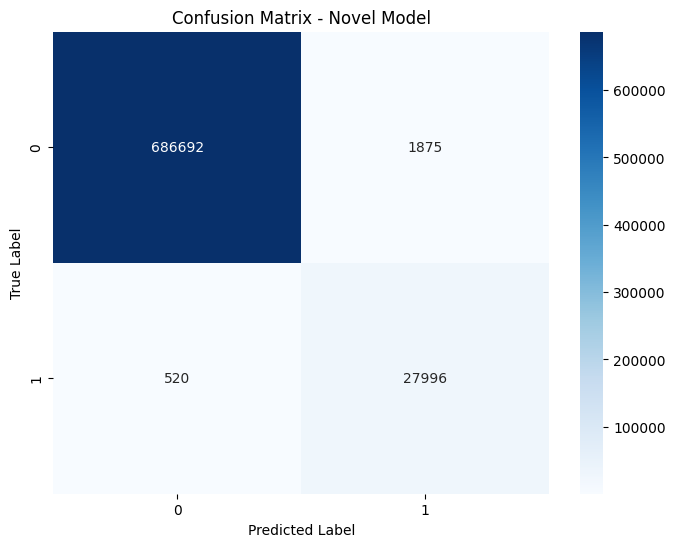

In [ ]:
def test_model(model, X_test_np, y_test_np, batch_size=1024):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for i in range(0, len(X_test_np), batch_size):
            batch_x = torch.tensor(X_test_np[i:i+batch_size], dtype=torch.float32).to(device)
            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())

    predictions = torch.cat(all_preds).numpy()
    y_true = y_test_np

    accuracy = (predictions == y_true).mean()

    print(f"Test Accuracy: {accuracy*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_true, predictions))

    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Novel Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, predictions, y_true

# Run test
print("Testing novel model...")
novel_accuracy, novel_predictions, novel_true_labels = test_model(model, X_test_np, y_test_np)


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'novel_graph_transformer_model.pth')
print("Model saved as 'novel_graph_transformer_model.pth'")

# Save results to file
results = {
    'model_type': 'SimpleGraphTransformer',
    'accuracy': novel_accuracy,
    'num_features': num_features,
    'dataset': 'NF-UNSW-NB15-v2'
}

import json
with open('model_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to 'model_results.json'")


Model saved as 'novel_graph_transformer_model.pth'
Results saved to 'model_results.json'


In [ ]:
def quick_test():
    """
    Run a quick test with random dummy data to check model pipeline
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create simple model (10 features, 2 classes)
    model = SimpleGraphTransformer(num_features=10, num_classes=2).to(device)

    # Dummy test data
    x = torch.randn(100, 10).to(device)   # 100 samples, 10 features
    y = torch.randint(0, 2, (100,)).to(device)  # binary labels

    model.eval()
    with torch.no_grad():
        output = model(x)
        _, predicted = torch.max(output, 1)
        accuracy = (predicted == y).float().mean()

    print(f"Quick test accuracy (dummy data): {accuracy.item()*100:.2f}%")
    return accuracy.item()


In [ ]:
def comprehensive_evaluation(model, X_test, y_test, device, batch_size=1024):
    """
    Comprehensive evaluation with multiple metrics
    """
    model.eval()
    all_preds = []
    all_labels = []

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    with torch.no_grad():
        for i in range(0, len(X_test_tensor), batch_size):
            batch_x = X_test_tensor[i:i+batch_size]
            batch_y = y_test_tensor[i:i+batch_size]

            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, f1_score
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Weighted F1 Score: {f1:.4f}")

    return all_preds, all_labels


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_results(labels, preds):
    """
    Plot confusion matrix and class distribution
    """
    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Class distribution
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(labels, bins=len(set(labels)), alpha=0.7, label='True')
    plt.title('True Labels Distribution')

    plt.subplot(1, 2, 2)
    plt.hist(preds, bins=len(set(preds)), alpha=0.7, label='Pred', color='orange')
    plt.title('Predicted Labels Distribution')
    plt.tight_layout()
    plt.show()


In [ ]:
quick_test()


Quick test accuracy (dummy data): 49.00%


0.49000000953674316

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize with same architecture used during training
model = SimpleGraphTransformer(num_features=X_test_np.shape[1], num_classes=2).to(device)

# Load weights
model.load_state_dict(torch.load("novel_graph_transformer_model.pth", map_location=device))
model.eval()


SimpleGraphTransformer(
  (feature_extractor): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  )
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)

print("Sample Predictions:", predictions[:10].cpu().numpy())


Sample Predictions: [0 0 0 0 0 0 0 0 1 0]


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    688567
           1       0.94      0.98      0.96     28516

    accuracy                           1.00    717083
   macro avg       0.97      0.99      0.98    717083
weighted avg       1.00      1.00      1.00    717083

Confusion Matrix:
[[686692   1875]
 [   520  27996]]
Weighted F1 Score: 0.9967


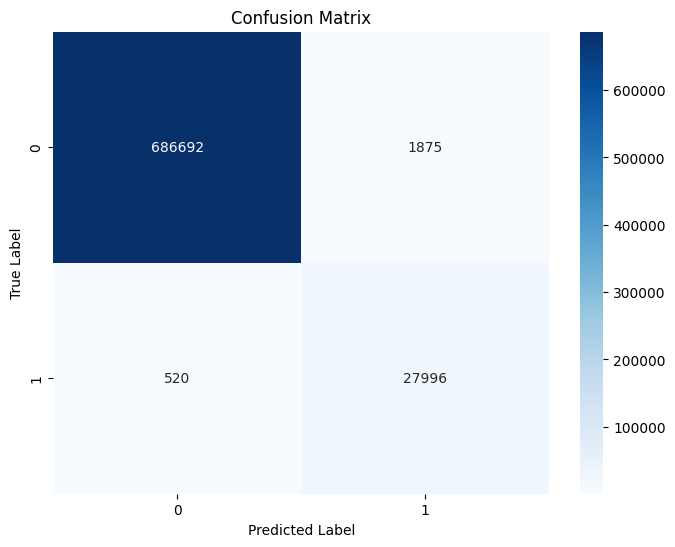

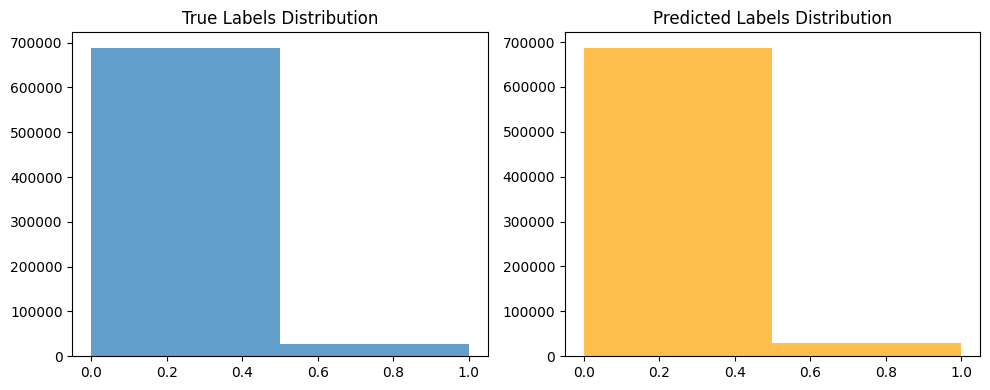

In [ ]:
# Use the functions you defined earlier in your notebook
preds, labels = comprehensive_evaluation(model, X_test_np, y_test_np, device)

# Plot confusion matrix & label distribution
plot_results(labels, preds)


In [ ]:
from sklearn.metrics import classification_report

# Generate report
report = classification_report(y_test_np, preds, target_names=["Normal (0)", "Attack (1)"])

# Save to text file
with open("classification_report.txt", "w") as f:
    f.write(report)

print("Classification report saved as classification_report.txt")


Classification report saved as classification_report.txt


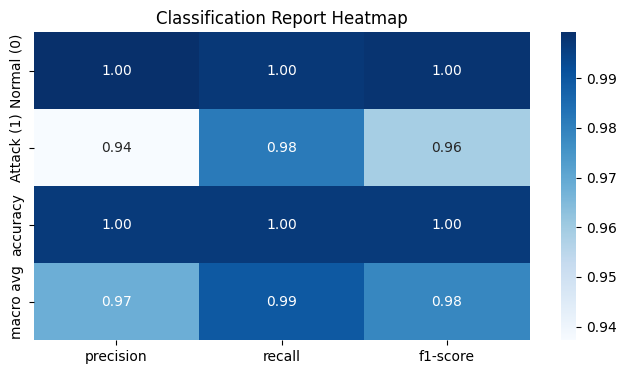

Classification report heatmap saved as images/classification_report.png


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert report to DataFrame
report_dict = classification_report(y_test_np, preds, target_names=["Normal (0)", "Attack (1)"], output_dict=True)
report_df = pd.DataFrame(report_dict).T

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.savefig("images/classification_report.png", dpi=300, bbox_inches="tight")
plt.show()

print("Classification report heatmap saved as images/classification_report.png")
